In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
import seaborn as sb
mpl.rcParams["figure.figsize"] = (15,8)
import numpy as np
import matplotlib.pyplot as plt
import stingray.simulator as ss
from stingray.lightcurve import Lightcurve
from stingray.events import EventList
from tqdm import tqdm
import matplotlib as mpl
import time

mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['ytick.major.size'] = 15
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['xtick.major.size'] = 15
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2


In [2]:
def pulsar_events_mp(length, period, ctrate, pulsed_fraction, mean_obs, bkg_ctrate, detlev, nbin = 128):
    
    BUFFER_LC = Lightcurve([0, 1], [1, 1], gti=[[-0.5, 1.5]], dt=1, err_dist='gauss')
    nustar_orb = 5808
    
    dt = period / 20
    # The total length of the time series should be the number of pointings times the time per orbit. 
    # Add one orbit for buffer.
    N_orb = int(round(length/mean_obs, 0))
    tot_len = (N_orb + 1)*nustar_orb
    times = numpy.arange(dt/2, tot_len + dt/2, dt)
    cont_lc = numpy.random.poisson((ctrate * (1 + pulsed_fraction * numpy.cos(2 * numpy.pi / period * times)) * dt)) + numpy.random.poisson(bkg_ctrate*dt, size=len(times))
    lc = BUFFER_LC
    lc.time = times
    lc.counts = cont_lc
    # The orbital period is 5808s. Every 5808s, a continuous observation with min_obs < length < max_obs begins
    start_t = numpy.multiply(numpy.arange(N_orb), numpy.random.normal(loc = nustar_orb, scale = 120, size = N_orb))
    point_t = numpy.random.normal(loc=mean_obs, scale = mean_obs/4, size = N_orb)
    end_t = numpy.add(start_t, point_t)
    exposure = numpy.sum(point_t)
    lc.gti = numpy.column_stack((start_t, end_t))
    lc.dt = dt
    events = EventList()
    events.gti = lc.gti
    events.simulate_times(lc)
    phase = numpy.arange(0, 1, 1 / nbin)
    zsq = z_n(phase, n=2,
              norm=fold_events(events.time, 1/period, nbin=nbin)[1])
    detected = zsq > detlev
    return (detected, exposure)



In [3]:
from astropy.table import Table
import ipyparallel as ipp
        
def detected_pulse_fraction_mp(pf_min, pf_max, length_min, length_max, 
                            ctrate_min=1.4, ctrate_max=1.4, 
                            period_min=1, period_max=1, n_realizations=1000, 
                            ntrial=1000, results=None, nbin=128, min_mean_obs = 3000, max_mean_obs = 3250, 
                            bkg_ctrate = 0, cores = 8):
    if results is None:
        results = Table(names=["period", "countrate", "pf", 
                               "length", "mean_obs", "detected"], 
                        dtype=[float, float, float, float, float, bool])

    pfs = 10**np.random.uniform(np.log10(pf_min), 
                                np.log10(pf_max), n_realizations)
    lengths = 10**np.random.uniform(np.log10(length_min), 
                                    np.log10(length_max), n_realizations)
    periods = 10**np.random.uniform(np.log10(period_min), 
                                    np.log10(period_max), n_realizations)
    ctrates = 10**np.random.uniform(np.log10(ctrate_min), 
                                    np.log10(ctrate_max), n_realizations)
    mean_obss = 10**np.random.uniform(np.log10(min_mean_obs), 
                                    np.log10(max_mean_obs), n_realizations)
    
    c = ipp.Client()
    v = c[:]
    with v.sync_imports():
        import numpy
        from stingray.events import EventList
        from stingray.lightcurve import Lightcurve
        from stingray.pulse.pulsar import z2_n_detection_level, z_n, fold_events
        
    detlev = z2_n_detection_level(ntrial=ntrial)
    map_results = v.map(pulsar_events_mp, lengths, periods, ctrates, pfs, mean_obss, [bkg_ctrate for i in range(n_realizations)], [detlev for i in range(n_realizations)])
    c.wait_interactive()
    c.shutdown()
    for i in range(n_realizations):
        pf, period, ctrate, mean_obs = pfs[i], periods[i], ctrates[i], mean_obss[i]
        detected, length = map_results[i]
        results.add_row([period, ctrate, pf, length, mean_obs, detected])
    
    return results
        

# High flux state

In [4]:
# Estimating the source and bkg rate from observation 30002038004
# Using all counts in A01_cl.evt file and circular r=45" source region, 80" bkg region
ctrate = 0.09
bkg = 0.01
period = 1.0
pfmin, pfmax = 0.02, 0.20
lengthmin, lengthmax = 10000, 200000
ctrate_min, ctrate_max = ctrate, ctrate
period_min, period_max = 1.0, 1.0

table_len_pf = detected_pulse_fraction_mp(pfmin, pfmax, lengthmin, lengthmax, 
                                ctrate_min, ctrate_max, period_min, period_max,
                                n_realizations=10000, ntrial=10000, bkg_ctrate = bkg)

   8/8 tasks finished after 1358 s
done


In [5]:
from sklearn.svm import SVC
linear_clf = SVC(kernel="linear",  C=1, probability=True)

In [6]:
idx = np.arange(len(table_len_pf), dtype=int)
indices_train = np.random.randint(0, len(table_len_pf), len(table_len_pf)//3)
indices_train = np.unique(indices_train)

indices = np.asarray([k for k in range(len(table_len_pf)) if k not in indices_train])
full_dataset = np.array(table_len_pf["pf", "length"])
dataset = np.take(full_dataset, indices)

labels = np.array(np.take(table_len_pf["detected"], indices))

training_dataset = np.take(full_dataset, indices_train)
labels_train = np.array(np.take(table_len_pf["detected"], indices_train))

features = np.zeros((len(dataset), len(list(dataset[0]))))
for i in range(len(dataset)):
    features[i, :] = list(dataset[i])

features_train = np.zeros((len(training_dataset), len(list(training_dataset[0]))))
for i in range(len(training_dataset)):
    features_train[i, :] = list(training_dataset[i])

In [7]:
linear_clf.fit(np.log10(features_train), labels_train)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [8]:
linear_clf.score(np.log10(features), labels)

0.8917900027925161

In [9]:
linear_clf.coef_, linear_clf.intercept_
const, pf_fact, len_fact = linear_clf.intercept_[0], linear_clf.coef_[0][0], linear_clf.coef_[0][1]

In [10]:
from IPython.display import display, Math, Latex
display(Math(r"${:.2f} + {:.2f} \log_{{10}} F + {:.2f} \log_{{10}} L = 0$".format(const, pf_fact, len_fact)))
display(Math(r"${:.2f} \log_{{10}} F + \log_{{10}} L = {:.2f}$".format(pf_fact / len_fact, -const / len_fact)))

display(Math(r"$F^{" + "{:.2f}".format(pf_fact / len_fact) + "}" + " L = {:.2f}$".format(10**(-const / len_fact))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

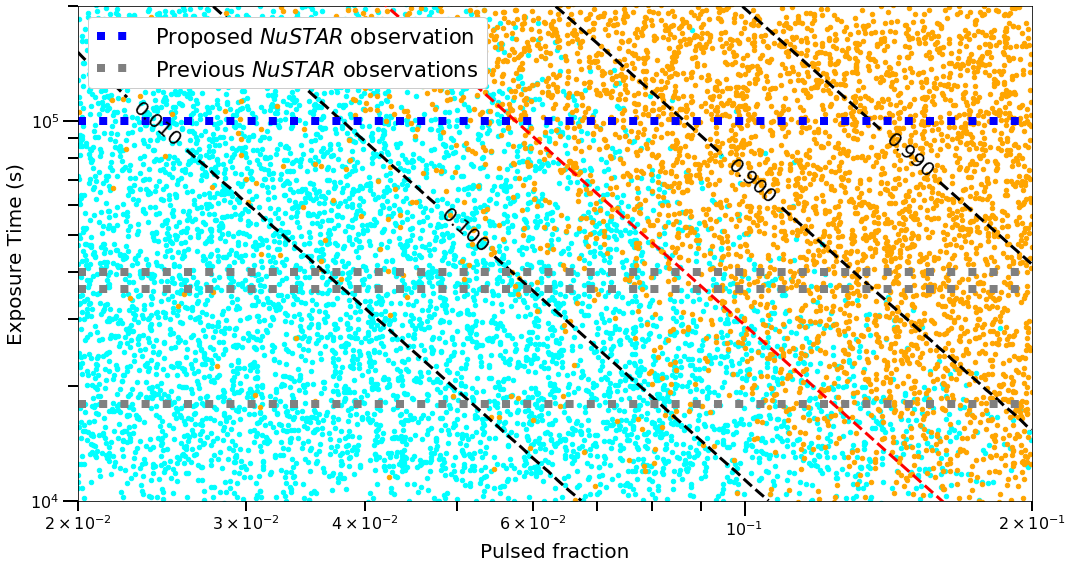

In [51]:
xs = np.linspace(pfmin, pfmax, 100)
ys = np.linspace(lengthmin, lengthmax, 100)
xx, yy = np.meshgrid(xs, ys)
Xfull = np.c_[xx.ravel(), yy.ravel()]

proba = linear_clf.predict_proba(np.log10(Xfull))

proba_detection = proba[:,1].reshape((100, 100))

plt.figure(figsize=(15, 8))

good = table_len_pf["detected"] == True
bad = np.logical_not(good)
plt.scatter(table_len_pf["pf"][bad], table_len_pf["length"][bad], color="cyan", s=20)
plt.scatter(table_len_pf["pf"][good], table_len_pf["length"][good], color="orange", s=20)
plt.xlabel("Pulsed fraction")
plt.ylabel("Exposure Time (s)")
plt.loglog()
plt.xlim([pfmin, pfmax])
plt.ylim([lengthmin, lengthmax])
# plt.([4e4, 1e5, 3e5])
plt.axhline(1.0e5, ls=':', color='blue', label='Proposed ' + r'$NuSTAR$' + ' observation', lw=8)
plt.axhline(1.8e4, ls=':', color='grey', lw=8)
plt.axhline(3.6e4, ls=':', color='grey', lw=8)
plt.axhline(4.0e4, ls=':', color='grey', label='Previous ' + r'$NuSTAR$' + ' observations', lw=8)

ax = plt.gca()
C_exp = -linear_clf.intercept_/linear_clf.coef_[0, 1]
F_exp = linear_clf.coef_[0, 0] / linear_clf.coef_[0, 1]
plt.plot(xs, 10**C_exp / xs ** F_exp, 'r--', lw=3, zorder=5)

print()
levels = [0.01, 0.1, 0.9, 0.99]
CS = plt.contour(xx, yy, proba_detection, levels, 
                 linestyles='dashed', colors='k')
plt.clabel(CS, inline=1, fontsize=20)
plt.legend(loc=2, fontsize=21, framealpha=1.0)
plt.tight_layout()
plt.savefig('/Users/sean/Desktop/CircinusULX5/2020/detection_len_pf_highflux.pdf')

# 100ks Period vs PF

In [101]:
lengthmin, lengthmax = 1e5, 1e5
pfmin, pfmax = 0.03, 0.2
period_min, period_max = 0.1, 10.0
ctrate = 0.09
bkg = 0.01
ctrate_min, ctrate_max = ctrate, ctrate


In [102]:
# !snakeviz pf_profile.prof

In [103]:
table_cnt_pf = detected_pulse_fraction_mp(pfmin, pfmax, lengthmin, lengthmax, 
                                ctrate_min, ctrate_max, period_min, period_max,
                                n_realizations=10000, ntrial=10000, bkg_ctrate = bkg)

   6/6 tasks finished after 4811 s
done


In [113]:
from sklearn.svm import SVC
linear_clf = SVC(kernel="linear",  C=1, probability=True)

In [114]:
idx = np.arange(len(table_cnt_pf), dtype=int)
indices_train = np.random.randint(0, len(table_cnt_pf), len(table_cnt_pf)//3)
indices_train = np.unique(indices_train)

indices = np.asarray([k for k in range(len(table_cnt_pf)) if k not in indices_train])
full_dataset = np.array(table_cnt_pf["pf", "period"])
dataset = np.take(full_dataset, indices)

labels = np.array(np.take(table_cnt_pf["detected"], indices))

training_dataset = np.take(full_dataset, indices_train)
labels_train = np.array(np.take(table_cnt_pf["detected"], indices_train))

features = np.zeros((len(dataset), len(list(dataset[0]))))
for i in range(len(dataset)):
    features[i, :] = list(dataset[i])

features_train = np.zeros((len(training_dataset), len(list(training_dataset[0]))))
for i in range(len(training_dataset)):
    features_train[i, :] = list(training_dataset[i])

In [115]:
linear_clf.fit(np.log10(features_train), labels_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [116]:
linear_clf.score(np.log10(features), labels)

0.8734477466164364

In [117]:
linear_clf.coef_, linear_clf.intercept_
const, pf_fact, ctr_fact = linear_clf.intercept_[0], linear_clf.coef_[0][0], linear_clf.coef_[0][1]

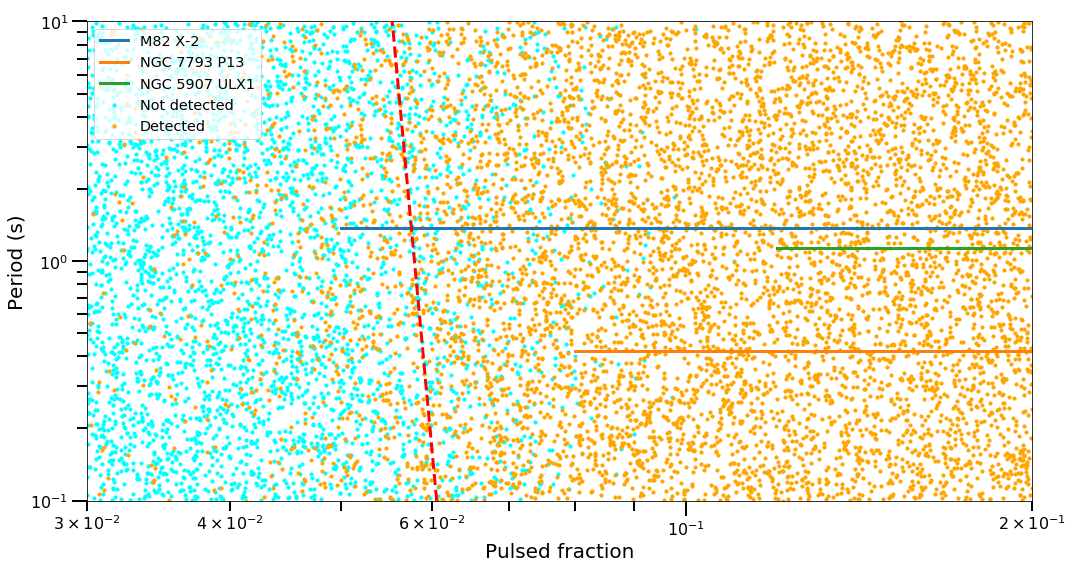

In [118]:
xs = np.linspace(pfmin, pfmax, 100)
ys = np.linspace(ctrate_min, ctrate_max, 100)
xx, yy = np.meshgrid(xs, ys)
Xfull = np.c_[xx.ravel(), yy.ravel()]

proba = linear_clf.predict_proba(np.log10(Xfull))

proba_detection = proba[:,1].reshape((100, 100))

plt.figure(figsize=(15, 8))
# plt.pcolormesh(xx, yy, proba_detection, cmap='Greys_r')
# plt.colorbar()

good = table_cnt_pf["detected"] == True
bad = np.logical_not(good)
plt.scatter(table_cnt_pf["pf"][bad], table_cnt_pf["period"][bad], color="cyan", 
            label="Not detected", s=10)
plt.scatter(table_cnt_pf["pf"][good], table_cnt_pf["period"][good], color="orange", 
            label="Detected", s=10)

plt.plot([0.05, 0.23], [1.37, 1.37], label = "M82 X-2")
plt.plot([0.08, 0.30], [0.42, 0.42], label = "NGC 7793 P13")
plt.plot([0.12, 0.20], [1.13, 1.13], label = "NGC 5907 ULX1")
plt.legend(loc = 2, fontsize='x-large')

plt.xlabel("Pulsed fraction")
plt.ylabel(r'Period (s)')
plt.loglog()
plt.xlim([pfmin, pfmax])
plt.ylim([period_min, period_max])
ax = plt.gca()
C_exp = -linear_clf.intercept_/linear_clf.coef_[0, 1]
F_exp = linear_clf.coef_[0, 0] / linear_clf.coef_[0, 1]
plt.plot(xs, 10**C_exp / xs ** F_exp, 'r--', lw=3, zorder=10)
plt.plot(xs, 10**(C_exp * (F_exp / 2)) / xs ** 2, color='grey', ls='--', lw=3, zorder=10)

print()
levels = [0.01, 0.1, 0.9, 0.99]
CS = plt.contour(xx, yy, proba_detection, levels, 
                 linestyles='dashed', colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.tight_layout()
plt.savefig('detection_pf_period_100ks_highflux.pdf')
#plt.savefig('detection_ctrate_pf.pdf')


# 40ks Period vs PF

In [5]:
lengthmin, lengthmax = 4e4, 4e4
pfmin, pfmax = 0.03, 0.2
period_min, period_max = 0.1, 10.0
ctrate = 0.09
bkg = 0.01
ctrate_min, ctrate_max = ctrate, ctrate


In [6]:
# !snakeviz pf_profile.prof

In [8]:
table_cnt_pf = detected_pulse_fraction_mp(pfmin, pfmax, lengthmin, lengthmax, 
                                ctrate_min, ctrate_max, period_min, period_max,
                                n_realizations=10000, ntrial=10000, bkg_ctrate = bkg)

   6/6 tasks finished after 1920 s
done


In [9]:
from sklearn.svm import SVC
linear_clf = SVC(kernel="linear",  C=1, probability=True)

In [10]:
idx = np.arange(len(table_cnt_pf), dtype=int)
indices_train = np.random.randint(0, len(table_cnt_pf), len(table_cnt_pf)//3)
indices_train = np.unique(indices_train)

indices = np.asarray([k for k in range(len(table_cnt_pf)) if k not in indices_train])
full_dataset = np.array(table_cnt_pf["pf", "period"])
dataset = np.take(full_dataset, indices)

labels = np.array(np.take(table_cnt_pf["detected"], indices))

training_dataset = np.take(full_dataset, indices_train)
labels_train = np.array(np.take(table_cnt_pf["detected"], indices_train))

features = np.zeros((len(dataset), len(list(dataset[0]))))
for i in range(len(dataset)):
    features[i, :] = list(dataset[i])

features_train = np.zeros((len(training_dataset), len(list(training_dataset[0]))))
for i in range(len(training_dataset)):
    features_train[i, :] = list(training_dataset[i])

In [11]:
linear_clf.fit(np.log10(features_train), labels_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [12]:
linear_clf.score(np.log10(features), labels)

0.8758736371260833

In [13]:
linear_clf.coef_, linear_clf.intercept_
const, pf_fact, ctr_fact = linear_clf.intercept_[0], linear_clf.coef_[0][0], linear_clf.coef_[0][1]

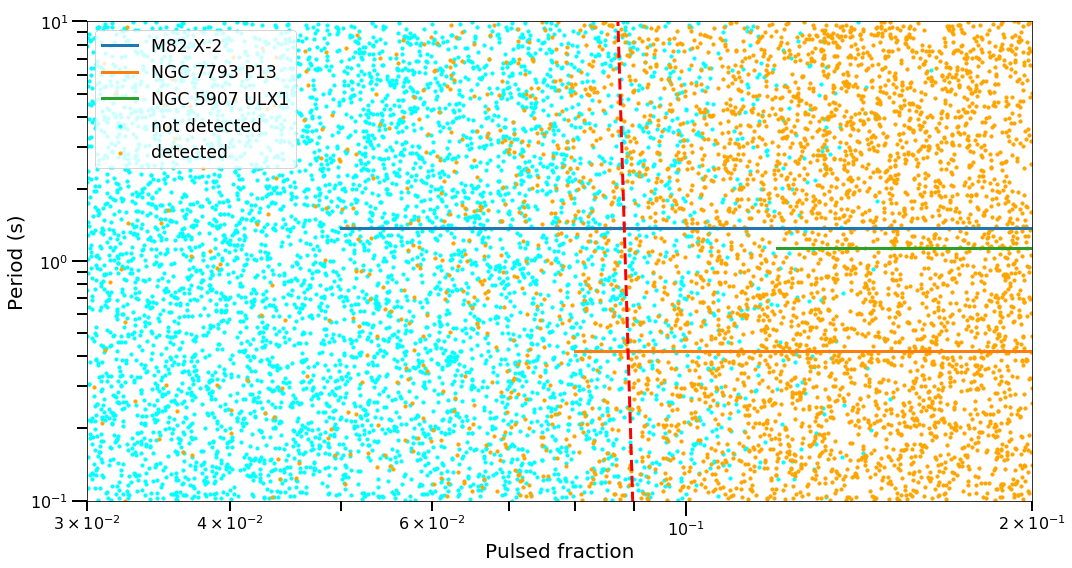

In [14]:
xs = np.linspace(pfmin, pfmax, 100)
ys = np.linspace(ctrate_min, ctrate_max, 100)
xx, yy = np.meshgrid(xs, ys)
Xfull = np.c_[xx.ravel(), yy.ravel()]

proba = linear_clf.predict_proba(np.log10(Xfull))

proba_detection = proba[:,1].reshape((100, 100))

plt.figure(figsize=(15, 8))
# plt.pcolormesh(xx, yy, proba_detection, cmap='Greys_r')
# plt.colorbar()

good = table_cnt_pf["detected"] == True
bad = np.logical_not(good)
plt.scatter(table_cnt_pf["pf"][bad], table_cnt_pf["period"][bad], color="cyan", s=10, label = 'not detected')
plt.scatter(table_cnt_pf["pf"][good], table_cnt_pf["period"][good], color="orange", s=10, label = 'detected')

plt.plot([0.05, 0.23], [1.37, 1.37], label = "M82 X-2")
plt.plot([0.08, 0.30], [0.42, 0.42], label = "NGC 7793 P13")
plt.plot([0.12, 0.20], [1.13, 1.13], label = "NGC 5907 ULX1")
plt.legend(loc=2, fontsize='xx-large')

plt.xlabel("Pulsed fraction")
plt.ylabel(r'Period (s)')
plt.loglog()
plt.xlim([0.03, pfmax])
plt.ylim([period_min, period_max])
ax = plt.gca()
C_exp = -linear_clf.intercept_/linear_clf.coef_[0, 1]
F_exp = linear_clf.coef_[0, 0] / linear_clf.coef_[0, 1]
plt.plot(xs, 10**C_exp / xs ** F_exp, 'r--', lw=3, zorder=10)
plt.plot(xs, 10**(C_exp * (F_exp / 2)) / xs ** 2, color='grey', ls='--', lw=3, zorder=10)

print()
levels = [0.01, 0.1, 0.9, 0.99]
CS = plt.contour(xx, yy, proba_detection, levels, 
                 linestyles='dashed', colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.tight_layout()
plt.savefig('detection_pf_period_40ks_highflux.pdf')
#plt.savefig('detection_ctrate_pf.pdf')



## 100ks Count rate vs PF, fixed length

In [15]:
lengthmin, lengthmax = 1e5, 1e5
pfmin, pfmax = 0.05, 0.5
period_min, period_max = 1.0,1.0
bkg = 0.01
ctrate_min, ctrate_max = 0.01, 0.1


In [16]:
# !snakeviz pf_profile.prof

In [17]:
# table_cnt_pf = detected_pulse_fraction(pfmin, pfmax, lengthmin, lengthmax, 
#                                 ctrate_min, ctrate_max, period_min, period_max,
#                                 n_realizations=1000, ntrial=1000, bkg_ctrate = bkg)

table_cnt_pf = detected_pulse_fraction_mp(pfmin, pfmax, lengthmin, lengthmax, 
                                ctrate_min, ctrate_max, period_min, period_max,
                                n_realizations=10000, ntrial=10000, bkg_ctrate = bkg)

   4/4 tasks finished after  549 s
done


In [18]:
from sklearn.svm import SVC
linear_clf = SVC(kernel="linear",  C=1, probability=True)

In [19]:
idx = np.arange(len(table_cnt_pf), dtype=int)
indices_train = np.random.randint(0, len(table_cnt_pf), len(table_cnt_pf)//3)
indices_train = np.unique(indices_train)

indices = np.asarray([k for k in range(len(table_cnt_pf)) if k not in indices_train])
full_dataset = np.array(table_cnt_pf["pf", "countrate"])
dataset = np.take(full_dataset, indices)

labels = np.array(np.take(table_cnt_pf["detected"], indices))

training_dataset = np.take(full_dataset, indices_train)
labels_train = np.array(np.take(table_cnt_pf["detected"], indices_train))

features = np.zeros((len(dataset), len(list(dataset[0]))))
for i in range(len(dataset)):
    features[i, :] = list(dataset[i])

features_train = np.zeros((len(training_dataset), len(list(training_dataset[0]))))
for i in range(len(training_dataset)):
    features_train[i, :] = list(training_dataset[i])

In [20]:
linear_clf.fit(np.log10(features_train), labels_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [21]:
linear_clf.score(np.log10(features), labels)

0.9317100475790652

In [22]:
linear_clf.coef_, linear_clf.intercept_
const, pf_fact, ctr_fact = linear_clf.intercept_[0], linear_clf.coef_[0][0], linear_clf.coef_[0][1]

In [23]:
from IPython.display import display, Math, Latex
display(Math(r"${:.2f} + {:.2f} \log_{{10}} F + {:.2f} \log_{{10}} C = 0$".format(const, pf_fact, ctr_fact)))
display(Math(r"${:.2f} \log_{{10}} F + \log_{{10}} C = {:.2f}$".format(pf_fact / ctr_fact, -const / ctr_fact)))

display(Math(r"$F^{" + "{:.2f}".format(pf_fact / ctr_fact) + "}" + " C = {:.2f}$".format(10**(-const / ctr_fact))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

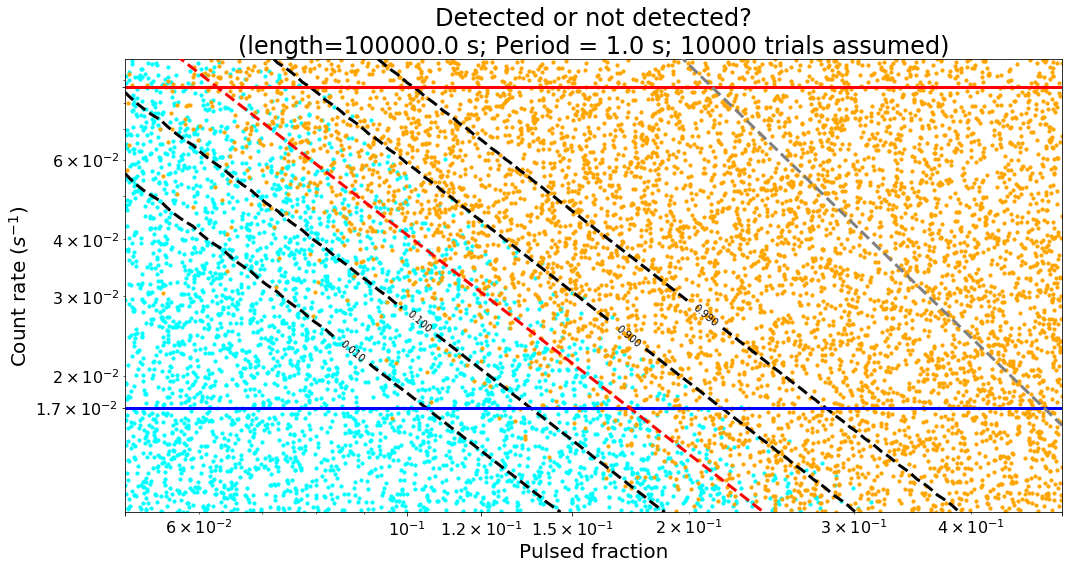

In [28]:
xs = np.linspace(pfmin, pfmax, 100)
ys = np.linspace(ctrate_min, ctrate_max, 100)
xx, yy = np.meshgrid(xs, ys)
Xfull = np.c_[xx.ravel(), yy.ravel()]

proba = linear_clf.predict_proba(np.log10(Xfull))

proba_detection = proba[:,1].reshape((100, 100))

plt.figure(figsize=(15, 8))
# plt.pcolormesh(xx, yy, proba_detection, cmap='Greys_r')
# plt.colorbar()

good = table_cnt_pf["detected"] == True
bad = np.logical_not(good)
plt.scatter(table_cnt_pf["pf"][bad], table_cnt_pf["countrate"][bad], color="cyan", 
            label="Not detected", s=10)
plt.scatter(table_cnt_pf["pf"][good], table_cnt_pf["countrate"][good], color="orange", 
            label="Detected", s=10)
plt.title("Detected or not detected?\n"
          "(length={} s; Period = {} s; 10000 trials assumed)".format(lengthmin, period_min))
plt.xlabel("Pulsed fraction")
plt.ylabel(r'Count rate ($s^{-1}$)')
plt.loglog()
plt.xlim([pfmin, pfmax])
plt.ylim([ctrate_min, ctrate_max])
plt.xticks([0.05, 0.1, 0.12, 0.15, 0.5])
# plt.yticks([200, 500, 1000, 2000])
ax = plt.gca()
# xticks = np.arange(pfmin, pfmax, 0.05)
# yticks = [200, 500, 1000, 2000, 5000, 10000, 20000]
# ax.set_xticks(xticks)
# ax.set_yticks(yticks)
# ax.set_xticklabels(['{:.2f}'.format(x) for x in xticks])
# ax.set_yticklabels(['{:d}'.format(y) for y in yticks])
# for x in xticks:
#     plt.axvline(x, color='grey', ls='--', zorder=10)
# for y in yticks:
#     plt.axhline(y, color='grey', ls='--', zorder=10)
# plt.ticklabel_format(style='plain')
C_exp = -linear_clf.intercept_/linear_clf.coef_[0, 1]
F_exp = linear_clf.coef_[0, 0] / linear_clf.coef_[0, 1]
plt.plot(xs, 10**C_exp / xs ** F_exp, 'r--', lw=3, zorder=10)
plt.plot(xs, 10**(C_exp * (F_exp / 2)) / xs ** 2, color='grey', ls='--', lw=3, zorder=10)

print()
levels = [0.01, 0.1, 0.9, 0.99]
CS = plt.contour(xx, yy, proba_detection, levels, 
                 linestyles='dashed', colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.axhline(0.017, color='blue')
plt.axhline(0.087, color='red')
plt.yticks([0.017, 0.087])
plt.tight_layout()
plt.savefig('detection_pf_ctrate_100ks.pdf')
#plt.savefig('detection_ctrate_pf.pdf')



## 200ks Count rate vs PF, fixed length

In [71]:
lengthmin, lengthmax = 2e5, 2e5
pfmin, pfmax = 0.05, 0.5
period_min, period_max = 1.0,1.0
bkg = 0.01
ctrate_min, ctrate_max = 0.01, 0.1


In [72]:
# !snakeviz pf_profile.prof

In [73]:
# table_cnt_pf = detected_pulse_fraction(pfmin, pfmax, lengthmin, lengthmax, 
#                                 ctrate_min, ctrate_max, period_min, period_max,
#                                 n_realizations=1000, ntrial=1000, bkg_ctrate = bkg)

table_cnt_pf = detected_pulse_fraction_mp(pfmin, pfmax, lengthmin, lengthmax, 
                                ctrate_min, ctrate_max, period_min, period_max,
                                n_realizations=10000, ntrial=10000, bkg_ctrate = bkg)

   4/4 tasks finished after  834 s
done


In [74]:
from sklearn.svm import SVC
linear_clf = SVC(kernel="linear",  C=1, probability=True)

In [76]:
idx = np.arange(len(table_cnt_pf), dtype=int)
indices_train = np.random.randint(0, len(table_cnt_pf), len(table_cnt_pf)//3)
indices_train = np.unique(indices_train)

indices = np.asarray([k for k in range(len(table_cnt_pf)) if k not in indices_train])
full_dataset = np.array(table_cnt_pf["pf", "countrate"])
dataset = np.take(full_dataset, indices)

labels = np.array(np.take(table_cnt_pf["detected"], indices))

training_dataset = np.take(full_dataset, indices_train)
labels_train = np.array(np.take(table_cnt_pf["detected"], indices_train))

features = np.zeros((len(dataset), len(list(dataset[0]))))
for i in range(len(dataset)):
    features[i, :] = list(dataset[i])

features_train = np.zeros((len(training_dataset), len(list(training_dataset[0]))))
for i in range(len(training_dataset)):
    features_train[i, :] = list(training_dataset[i])

In [77]:
linear_clf.fit(np.log10(features_train), labels_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [78]:
linear_clf.score(np.log10(features), labels)

0.9419499230661631

In [79]:
linear_clf.coef_, linear_clf.intercept_
const, pf_fact, ctr_fact = linear_clf.intercept_[0], linear_clf.coef_[0][0], linear_clf.coef_[0][1]

In [80]:
from IPython.display import display, Math, Latex
display(Math(r"${:.2f} + {:.2f} \log_{{10}} F + {:.2f} \log_{{10}} C = 0$".format(const, pf_fact, ctr_fact)))
display(Math(r"${:.2f} \log_{{10}} F + \log_{{10}} C = {:.2f}$".format(pf_fact / ctr_fact, -const / ctr_fact)))

display(Math(r"$F^{" + "{:.2f}".format(pf_fact / ctr_fact) + "}" + " C = {:.2f}$".format(10**(-const / ctr_fact))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

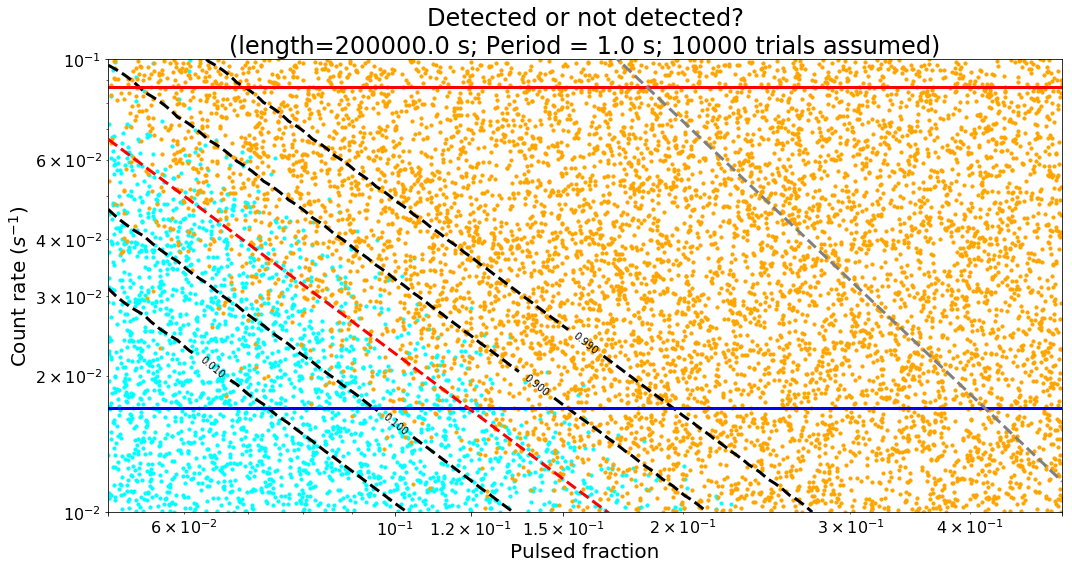

In [81]:
xs = np.linspace(pfmin, pfmax, 100)
ys = np.linspace(ctrate_min, ctrate_max, 100)
xx, yy = np.meshgrid(xs, ys)
Xfull = np.c_[xx.ravel(), yy.ravel()]

proba = linear_clf.predict_proba(np.log10(Xfull))

proba_detection = proba[:,1].reshape((100, 100))

plt.figure(figsize=(15, 8))
# plt.pcolormesh(xx, yy, proba_detection, cmap='Greys_r')
# plt.colorbar()

good = table_cnt_pf["detected"] == True
bad = np.logical_not(good)
plt.scatter(table_cnt_pf["pf"][bad], table_cnt_pf["countrate"][bad], color="cyan", 
            label="Not detected", s=10)
plt.scatter(table_cnt_pf["pf"][good], table_cnt_pf["countrate"][good], color="orange", 
            label="Detected", s=10)
plt.title("Detected or not detected?\n"
          "(length={} s; Period = {} s; 10000 trials assumed)".format(lengthmin, period_min))
plt.xlabel("Pulsed fraction")
plt.ylabel(r'Count rate ($s^{-1}$)')
plt.loglog()
plt.xlim([pfmin, pfmax])
plt.ylim([ctrate_min, ctrate_max])
plt.xticks([0.05, 0.1, 0.12, 0.15, 0.5])
# plt.yticks([200, 500, 1000, 2000])
ax = plt.gca()
# xticks = np.arange(pfmin, pfmax, 0.05)
# yticks = [200, 500, 1000, 2000, 5000, 10000, 20000]
# ax.set_xticks(xticks)
# ax.set_yticks(yticks)
# ax.set_xticklabels(['{:.2f}'.format(x) for x in xticks])
# ax.set_yticklabels(['{:d}'.format(y) for y in yticks])
# for x in xticks:
#     plt.axvline(x, color='grey', ls='--', zorder=10)
# for y in yticks:
#     plt.axhline(y, color='grey', ls='--', zorder=10)
# plt.ticklabel_format(style='plain')
C_exp = -linear_clf.intercept_/linear_clf.coef_[0, 1]
F_exp = linear_clf.coef_[0, 0] / linear_clf.coef_[0, 1]
plt.plot(xs, 10**C_exp / xs ** F_exp, 'r--', lw=3, zorder=10)
plt.plot(xs, 10**(C_exp * (F_exp / 2)) / xs ** 2, color='grey', ls='--', lw=3, zorder=10)

print()
levels = [0.01, 0.1, 0.9, 0.99]
CS = plt.contour(xx, yy, proba_detection, levels, 
                 linestyles='dashed', colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.axhline(0.017, color='blue')
plt.axhline(0.087, color='red')
ax.set_yticklabels(['0.017','0.087'], [0.017, 0.087])
plt.tight_layout()
plt.savefig('detection_pf_ctrate_200ks.pdf')
#plt.savefig('detection_ctrate_pf.pdf')


# Simulations for Hannah

In [62]:
lengthmin, lengthmax = 4.8e4, 4.8e4
pfmin, pfmax = 0.03, 0.2
period_min, period_max = 0.1, 10.0
ctrate = 0.0095
bkg = 0.022
ctrate_min, ctrate_max = ctrate, ctrate


In [63]:
# !snakeviz pf_profile.prof

In [ ]:
table_cnt_pf = detected_pulse_fraction_mp(pfmin, pfmax, lengthmin, lengthmax, 
                                ctrate_min, ctrate_max, period_min, period_max,
                                n_realizations=10000, ntrial=10000, bkg_ctrate = bkg)

   0/6 tasks finished after  669 s

In [36]:
from sklearn.svm import SVC
linear_clf = SVC(kernel="linear",  C=1, probability=True)

In [37]:
idx = np.arange(len(table_cnt_pf), dtype=int)
indices_train = np.random.randint(0, len(table_cnt_pf), len(table_cnt_pf)//3)
indices_train = np.unique(indices_train)

indices = np.asarray([k for k in range(len(table_cnt_pf)) if k not in indices_train])
full_dataset = np.array(table_cnt_pf["pf", "period"])
dataset = np.take(full_dataset, indices)

labels = np.array(np.take(table_cnt_pf["detected"], indices))

training_dataset = np.take(full_dataset, indices_train)
labels_train = np.array(np.take(table_cnt_pf["detected"], indices_train))

features = np.zeros((len(dataset), len(list(dataset[0]))))
for i in range(len(dataset)):
    features[i, :] = list(dataset[i])

features_train = np.zeros((len(training_dataset), len(list(training_dataset[0]))))
for i in range(len(training_dataset)):
    features_train[i, :] = list(training_dataset[i])

In [38]:
linear_clf.fit(np.log10(features_train), labels_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [39]:
linear_clf.score(np.log10(features), labels)

0.8896842105263157

In [40]:
linear_clf.coef_, linear_clf.intercept_
const, pf_fact, ctr_fact = linear_clf.intercept_[0], linear_clf.coef_[0][0], linear_clf.coef_[0][1]

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


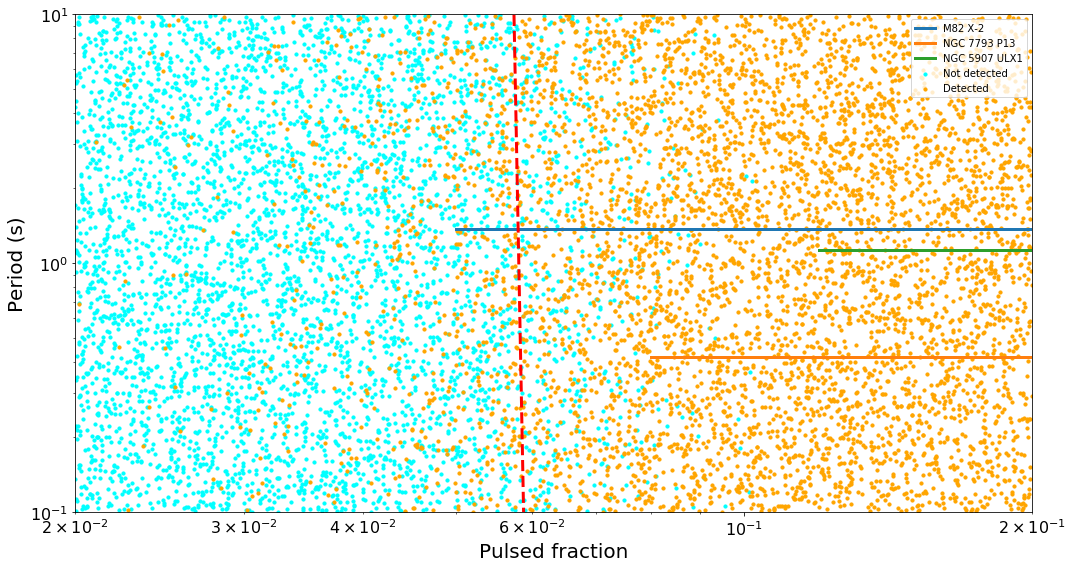

In [44]:
xs = np.linspace(pfmin, pfmax, 100)
ys = np.linspace(ctrate_min, ctrate_max, 100)
xx, yy = np.meshgrid(xs, ys)
Xfull = np.c_[xx.ravel(), yy.ravel()]

proba = linear_clf.predict_proba(np.log10(Xfull))

proba_detection = proba[:,1].reshape((100, 100))

plt.figure(figsize=(15, 8))
# plt.pcolormesh(xx, yy, proba_detection, cmap='Greys_r')
# plt.colorbar()

good = table_cnt_pf["detected"] == True
bad = np.logical_not(good)
plt.scatter(table_cnt_pf["pf"][bad], table_cnt_pf["period"][bad], color="cyan", 
            label="Not detected", s=10)
plt.scatter(table_cnt_pf["pf"][good], table_cnt_pf["period"][good], color="orange", 
            label="Detected", s=10)

plt.plot([0.05, 0.23], [1.37, 1.37], label = "M82 X-2")
plt.plot([0.08, 0.30], [0.42, 0.42], label = "NGC 7793 P13")
plt.plot([0.12, 0.20], [1.13, 1.13], label = "NGC 5907 ULX1")
plt.legend(loc = 2, fontsize='x-large')

plt.xlabel("Pulsed fraction")
plt.ylabel(r'Period (s)')
plt.loglog()
plt.xlim([pfmin, pfmax])
plt.ylim([period_min, period_max])
ax = plt.gca()
C_exp = -linear_clf.intercept_/linear_clf.coef_[0, 1]
F_exp = linear_clf.coef_[0, 0] / linear_clf.coef_[0, 1]
plt.plot(xs, 10**C_exp / xs ** F_exp, 'r--', lw=3, zorder=10)
plt.plot(xs, 10**(C_exp * (F_exp / 2)) / xs ** 2, color='grey', ls='--', lw=3, zorder=10)

print()
levels = [0.01, 0.1, 0.9, 0.99]
CS = plt.contour(xx, yy, proba_detection, levels, 
                 linestyles='dashed', colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.tight_layout()
plt.savefig('detection_pf_period_48ks_HPE.pdf')
